# Word Embeddings
We will use word2vec with gensim to solve word similarity and analogy tasks. Use gensim's [word2vec tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) for a reference of the functions we need.

First, we download the word embeddings pretrained on the (private) Google News corpus. The embeddings are quite big with 1.7 GB. They will be downloaded to your `<HOME>/gensim-data` directory.

In [1]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Let's look at the vector size, vocabulary size and its first 10 and last 5 words.

In [2]:
print(wv.vector_size)
print(len(wv.index_to_key))
print(wv.index_to_key[:10])
print(wv.index_to_key[-5:])

300
3000000
['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']
['RAFFAELE', 'Bim_Skala_Bim', 'Mezze_Cafe', 'pulverizes_boulders', 'snowcapped_Caucasus']


Get the vectors for woman, man, queen and king.

In [3]:
vectors = [wv[word] for word in ['woman', 'man', 'king', 'queen']]
print(len(vectors))

4


Compute their norms. Are they normalized?

In [4]:
import numpy as np

norms = [np.linalg.norm(v) for v in vectors]
print(norms)

[2.6556242, 2.3106172, 2.9022589, 3.0283043]


## Word Similarity
We will now perform a few operations that use word similarity.

Given the pairs below...

In [5]:
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'democracy'),
]

... compute the word similarity of each pair, once with [sklearn's cosine similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html), and once with gensim's similarity.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for w1, w2 in pairs:
    print(w1, w2, cosine_similarity(wv[w1].reshape(1, -1), wv[w2].reshape(1, -1))[0][0], wv.similarity(w1, w2))
    #is the same

car minivan 0.69070363 0.6907037
car bicycle 0.5364484 0.5364484
car airplane 0.4243558 0.42435578
car cereal 0.13924746 0.13924746
car democracy 0.078821905 0.07882191


Find the most similar word to all of the words: bike, train, plane, car, bus.

In [10]:
wv.most_similar(positive=['bike', 'train', 'plane', 'car', 'bus'], topn=5)

[('bicycle', 0.6787395477294922),
 ('scooter', 0.6726157069206238),
 ('van', 0.6673939228057861),
 ('buses', 0.6520541906356812),
 ('vehicle', 0.6501880288124084)]

**Odd one out.** Find the term that doesn't fit the rest of the list: fire, water, land, car, sea, air.

In [11]:
print(wv.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car']))

car


Let's evaluate our word vectors on the WordSim353 dataset. You can get it from `datapath('wordsim353.tsv')` (import `datapath` from `gensim.test.utils`). What's the Pearson correlation?

In [12]:
from gensim.test.utils import datapath

similarity = wv.evaluate_word_pairs(datapath('wordsim353.tsv'))
print(similarity)

(PearsonRResult(statistic=0.6238773472434951, pvalue=1.7963233960134136e-39), SignificanceResult(statistic=0.6589215888009288, pvalue=2.5346056459149263e-45), 0.0)


## Word Analogy
We also want to evaluate our word embeddings on the word analogy task. The test set from the original word2vec paper also comes with gensim, and is found in `datapath('questions-words.txt')`. Let's look at the categories that are present in the test file.

In [16]:
with open(datapath('questions-words.txt')) as f:
    for i, line in enumerate(f):
        if line.startswith(':'):
            print(i, line.strip())

0 : capital-common-countries
507 : capital-world
5032 : currency
5899 : city-in-state
8367 : family
8874 : gram1-adjective-to-adverb
9867 : gram2-opposite
10680 : gram3-comparative
12013 : gram4-superlative
13136 : gram5-present-participle
14193 : gram6-nationality-adjective
15793 : gram7-past-tense
17354 : gram8-plural
18687 : gram9-plural-verbs


To save us some computation time, we're just going to use the first category, `capital-common-countries`. We store its evaluation examples in a new text file `word-analogies.txt`.

In [17]:
lines = []
with open(datapath('questions-words.txt')) as f:
    for line in f:
        if line.startswith(': capital-world'):
            break
        lines.append(line)
print(lines[:10])
with open(datapath('word-analogies.txt'), 'w') as f:
    f.writelines(lines)

[': capital-common-countries\n', 'Athens Greece Baghdad Iraq\n', 'Athens Greece Bangkok Thailand\n', 'Athens Greece Beijing China\n', 'Athens Greece Berlin Germany\n', 'Athens Greece Bern Switzerland\n', 'Athens Greece Cairo Egypt\n', 'Athens Greece Canberra Australia\n', 'Athens Greece Hanoi Vietnam\n', 'Athens Greece Havana Cuba\n']


Now we can evaluate our model with gensim's built-in function `evaluate_word_analogies`. Save the results to a variable `analogy_scores`.

In [18]:
analogy_scores = wv.evaluate_word_analogies(datapath('word-analogies.txt'))

Print the accuracy and show an example of a correctly solved analogy, and an incorrectly solved one.

In [25]:
print(f"Accuracy: {analogy_scores[0]:.2f}")
print(analogy_scores[1][0]['section'])
print(analogy_scores[1][1]['section'])
print(analogy_scores[1][0].keys())
print(analogy_scores[1][0]['correct'][0])
print(analogy_scores[1][0]['incorrect'][0])

Accuracy: 0.83
capital-common-countries
Total accuracy
dict_keys(['section', 'correct', 'incorrect'])
('ATHENS', 'GREECE', 'BANGKOK', 'THAILAND')
('ATHENS', 'GREECE', 'BAGHDAD', 'IRAQ')


## Visualization
Let's visualize our word embeddings in two dimensions. We use PCA to reduce the dimensionality of our 300-dim word vectors to 2. Below is a function `display_scatterplot` that takes a list of words as input and plots them in 2D.

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

def display_scatterplot(model, words): # assumes all words are in the vocabulary
    word_vectors = [model[word] for word in words]
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x + 0.03, y + 0.03, word)

Define a list of words that could be present in an analogy task. Plot their down-projected embeddings. Can you detect a vector for the relation of your analogy?

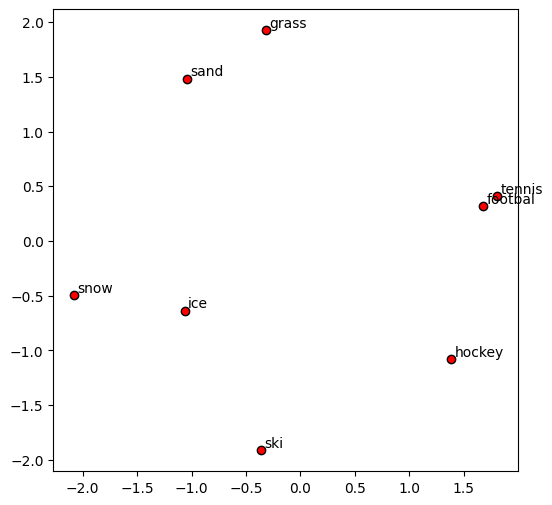

In [28]:
sports_and_surfaces = ['footbal', 'grass', 'ski', 'snow', 'hockey', 'ice', 'tennis', 'sand']
display_scatterplot(wv, sports_and_surfaces)

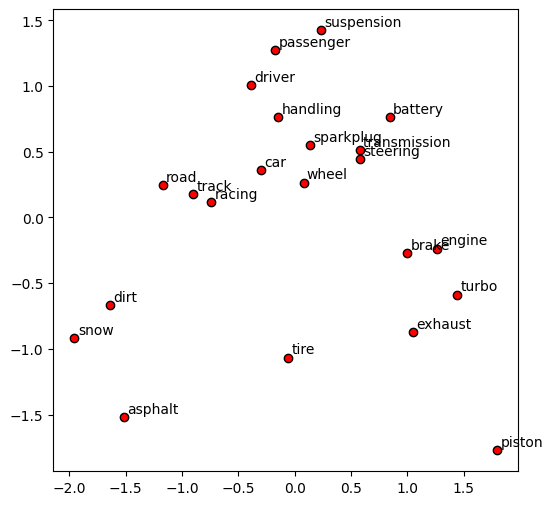

In [39]:
sports_and_surfaces = ['car', 'engine', 'wheel', 'piston', 'battery', 'racing', 'turbo', 'tire', 'asphalt', 'dirt', 'snow', 'sparkplug', 'exhaust', 'brake', 'suspension', 'transmission', 'steering', 'driver', 'passenger', 'road', 'track', 'handling']
display_scatterplot(wv, sports_and_surfaces)

## Fun with words
Try your own skills in guessing the hidden word by entering words and receiving the cosine similarity on [Semantle](https://semantle.com/).